# GSS Data Analysis: Preliminary Modeling

## Helper Functions and Classes


#### Turning a DataFrame into a mapping (strings to numbers and back) dictionary

In [1]:
def recur_dictify(frame):
    '''Recursive function to turn the meta data dataframe into a dictionary for remapping values'''
    
    # Base Case
    if len(frame.columns) == 1:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    
    # Recursive Case
    grouped = frame.groupby(frame.columns[0])
    dictionary = {name: recur_dictify(group.iloc[:,1:]) for name,group in grouped}
    return dictionary

#### Getting the column names of the Nominal, Ordinal (and Continuous), and Binary columns

In [2]:
# We operate under the tested assumption that unless specified or over 11 distinct values,
# the column is ordinal.

# We end up with four distinct lists of columns that we will use in our data pipeline:
# Ordinal, Nominal, Binary, and Drop

# Note: We in fact will not use the Drop list in the pipelines, as we will just not select these columns


def GetColumnNames(df, Target_Variables = ['POLVIEWS']):
    '''Specialized Function to get the Ordinal, Nominal, and Binary column names.'''
    
    # Gets the dataframe column names alongisde the number of unique entries
    # Forms the basis of our rule system: if over 11 distinct categories then it is nominal
    df_columns = df.nunique()

    # Columns that may become exceptions to the rules
    Drop = ['ID_','DATEINTV','COHORT','SPOTHER','OTH16','OTHER']
    Continuous = ["YEAR","HRS1","HRS2","AGEWED","SPHRS1","SIBS","CHILDS","AGE","WHENHS","WHENCOL",
             "HOMPOP","CHLDIDEL","COHORT","BABIES","PRETEEN","TEENS","TVHOURS",'WEEKSWRK']
    Small_Categorical = ["REGION","WRKSTAT","MARITAL",'SPWRKSTA','PAWRKSLF','DIPGED','SECTOR','RACE','PARBORN',
                        'PRES00','VOTE04','PRES04','IF04WHO','VOTE00','VOTE08','PRES08',
                        'IF08WHO','VOTE12','PRES12','IF12WHO']
    Large_Ordinal = ['RINCOM06','RINCOME','INCOME']

    # Gets rid of all of the columns manually specified
    df_columns = df_columns[~(df_columns.index.isin(Drop)) &
                       ~(df_columns.index.isin(Continuous)) &
                       ~(df_columns.index.isin(Small_Categorical)) &
                       ~(df_columns.index.isin(Large_Ordinal)) &
                       ~(df_columns.index.isin(Target_Variables))]

    # Now we make the lists of columns one by one
    Nominal = list(df_columns[df_columns >= 11].index & df_columns[df_columns != 2].index)
    Nominal = Nominal + Small_Categorical
    # Checks to see if all of the list items are in the column index of the Df. If not, drop them.
    Nominal = [col for col in Nominal if col in df.columns]
    
    Ordinal = list(df_columns[df_columns <= 11].index & df_columns[df_columns != 2].index) 
    Ordinal = Ordinal + Continuous + Large_Ordinal
    Ordinal = [col for col in Ordinal if col in df.columns]
    
    Binary = list(df_columns[df_columns == 2].index)
    Binary = [col for col in Binary if col in df.columns]
    
    return Nominal, Ordinal, Binary

#### First Pipeline Classes

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    '''Selects columns given a list of column names and turns into Numpy Array'''
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class BinaryEncoding(BaseEstimator,TransformerMixin):
    '''Ensures that binary attirbutes are properly encoded while still retaining NaNs'''
    def fit(self,X,y=None):
        return self
    def transform(self,X, y=None):
        for col in  X.T:
            # While not a necessary feature in this instance, this is robust to missing values.
            col[(~np.isnan(col)) & (col!=np.nanmax(col))] = 0
            col[col==np.nanmax(col)] = 1
        return X
    
    
class DataFrameSelectorAndRecode(BaseEstimator, TransformerMixin):
    '''Same as DataFrameSelector, but also turns numbers into strings'''
    def __init__(self, attribute_names, remap_dict):
        self.attribute_names = attribute_names
        self.remap_dict = remap_dict 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[self.attribute_names]
        X = X.replace(self.remap_dict)
        return X.values


#### Second Pipeline Classes

In [4]:
# Note: These classes are different from the other classes. They expect a dataframe input and output a dataframe.

class UniqueThreshold(BaseEstimator, TransformerMixin):
    '''Drops columns that exceed a given amount of unqiues'''
    def __init__(self, threshold = 20, ignore_columns=None):
        self.max_unique = threshold
        self.keep_cols = ignore_columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # We must code carefully to avoid getting rid of ordinal column values
    
        # Makes a list of all columns in X
        columns = list(X.columns)
        
        # Selects all of the columns that we want to filter for unique values 
        # (i.e. non-ordinal b/c it will inflate the amount of columns)
        non_ordinal_columns = [x for x in columns if x not in self.keep_cols]
        
        # Selects the columns that we want to filter 
        X_filtered = X.loc[:,non_ordinal_columns]
        
        # Sets a boolean index and uses it to filter our columns
        critera = (X_filtered.nunique() <= self.max_unique)
        under_thresh = list(critera.index[critera])
        
        # Gets the filtered columns and also puts in all ordinal columns
        X_filtered = X.loc[:, under_thresh + self.keep_cols]
        return X_filtered
    
        

class FilterNAs(BaseEstimator, TransformerMixin):
    '''Drops columns that exceed a given amount of NAs'''
    def __init__(self, threshold = .5):
        self.d_per = 1-threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        new_thresh = self.d_per * X.shape[0]
        X.dropna(thresh=new_thresh, inplace=True, axis = 1)
        return X    

#### Quick Fitting Multiple Models

In [5]:
from sklearn.model_selection import cross_val_score

def QuickModel(ml_algo,names,X,y):
    '''Quick modeling and cross validation for multiple models'''
    for algo,name in zip(ml_algo,names):
        Model = algo
        Model = Model.fit(X,y)
        print(name, 'Cross Validation:', cross_val_score(Model,X,y,cv=5,scoring='r2'))

## Cleaning the data

The data currently comes in an all numeric format, making visuals and understanding the data difficult. Additionaly, all NAs seem like actual values. Cleaning the data is the first step in analysis.

### Step One: Converting the data to and from Strings

We can use the metadata included with the data download to easily remap strings to numbers and back.

In [6]:
# We must be careful with displaying all rows, as displaying too many can make the notebook become very slow
# pd.set_option('display.max_rows', 100000)

In [7]:
import numpy as np
import pandas as pd 

In [8]:
# Loading in the data

df = pd.read_csv('data/GSS.csv')

In [9]:
# Using the meta data as a tool for converting the numeric values of the df into strings and then back

df_remap  = pd.read_excel('data/GSS_metadata.xlsx',sheet_name='Codes')
df_remap = df_remap.iloc[:,1:]
df_remap = df_remap.fillna(method='ffill')
df_remap['Variable Name'] = df_remap['Variable Name'].str.upper()

In [10]:
# This dataframe will help turn the strings back into numbers
# This will help speed up recoding ordinal values for machine learning

df_remap_reverse = df_remap[['Variable Name','Label','Code']]

In [11]:
remaper = recur_dictify(df_remap)
remaper_reverse = recur_dictify(df_remap_reverse)

In [12]:
# Converts the numbers to strings and drops NAs

df_strings = df.replace(remaper)
df_strings = df_strings.replace(["No answer","Don't know","Not applicable","-1"],np.NaN)
# df_strings.to_csv('data/data_strings.csv', index=False)
df_strings = pd.read_csv('data/data_strings.csv', low_memory=False)

In [13]:
# We must be more specific to convert strings back into numbers
# This is because the pandas 'replace' function fails for the 'remaper_reverse' dictionary

df = df_strings
for key in remaper_reverse.keys():
    df[key] = df_strings[key].map(remaper_reverse[key]).fillna(df_strings[key])

# df = df[list(df_strings.columns)]
# df.to_csv('data/data_clean.csv', index=False)

### Aside: Quick Graphs
While the dataframe of string values may not be good for machine learning, it can be a great tool for visualization.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [ ]:
df_strings = pd.read_csv('data/data_strings.csv', low_memory=False)

In [ ]:
x = df_strings['HOMOSEX'].value_counts().index
y = df_strings['HOMOSEX'].value_counts().values
fig, ax = plt.subplots()
ax.barh(x,y)
plt.show()

In [ ]:
df_graph = df_strings
df_graph['Before2000'] = ['Before 2000' if x < 2000 else '2000 and after' for x in df['YEAR']]
df_graph_bar = df_graph.groupby(['HOMOSEX','Before2000']).size() #.reset_index(name='counts')

In [15]:
df_graph_bar = df_graph_bar.groupby(level=1) \
.apply(lambda x:100 * x / float(x.sum())) \
.reset_index(name='proportion')

NameError: name 'df_graph_bar' is not defined

In [ ]:
df_graph_bar = df_graph_bar.pivot(index='HOMOSEX', columns='Before2000', values='proportion')

In [ ]:
ax = df_graph_bar.plot(kind='barh')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
plt.title('Opinions of Same-Sex Marriage',
         fontdict = {'fontsize' : 20})
plt.legend(title= 'Time Period')

plt.show()

### Step Two: Preparing the Data Pipelines

In order to work use machine learning models, we have to dummy encode categoricals and keep ordinal values as numbers. Recoding the columns can be mostly automated, as most variables are ordinal. The implementation is done through sklearn pipelines with custom functions.

__**Current Assumptions**__

* Ordinals are scaled, assumed to be continous. This is assumption seems reasonable given most of our ordinal columns have even steps inbetween levels.

__**Special Cases**__

* helpful,fair,trust,age - 3 to 2
* Premarsx, teensex, xmarsex, homosex, bible - 'other' trouble
    * 'other' appears to not be entered within the data after 2000
* Nominal attributes under 11 - spjewaj, sprel?, relig16?, denom16?, relig?, parborn, race, sector, dipged, pawrkslf, spwrksta, marital, wrkstat, region
    * presidental - i.e. vote12,pres12,if12who,...
* tax - R pays none<vol.>/4
    * 'R pays none<vol.>/4' appears to not be entered within the data after 2000
* ordinal w/ large amount of categories - rincom06,rincome,income
* Drop: ID, dateinv, cohort: these are primarly for record keeping purposes
* 'SPOTHER','OTH16','OTHER' appear to strings

In [16]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [17]:
df = pd.read_csv('data/data_clean.csv', low_memory = False)
Nominal, Ordinal, Binary = GetColumnNames(df)

In [18]:
ordinal_pipeline = Pipeline([
    ('selector', DataFrameSelector(Ordinal)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('selector', DataFrameSelector(Nominal)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encode', OneHotEncoder(categories='auto'))
])

binary_pipeline = Pipeline([
     ('selector', DataFrameSelector(Binary)),
     ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('binary', BinaryEncoding())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("ord_pipe", ordinal_pipeline),
    ('nom_pipe', nominal_pipeline),
    ('bin_pipe', binary_pipeline)
])

In [19]:
# First, let's only include enteries after 1999 and where POLVIEWS is not NA
df_filtered = df[(df['YEAR'] > 2000) & ~(df['POLVIEWS'] == np.NaN)]

# Second let's use the polviews as the primary variable
X_df = df_filtered.drop('POLVIEWS', axis = 1)
y = df_filtered['POLVIEWS']

In [20]:
X = full_pipeline.fit_transform(X_df)

In [21]:
X.shape

(21533, 1816)

### Step Three: Modifying the Pipeline

Note: We do not need to do a test train split, as we will use cross validation

Here is the shape of our first processed data: 
![First_Pipeline](data/img/First_Pipeline.png)

Unfortunately, the many different categories of some nominal columns casued our new dataframe to have 1819 columns. This seems to be an extremely sparse matrix which will be difficult for most modeling techniques. Perhaps latter, we can return with methods such as neural network to deal with this sparisty. For now, we should drop columns with too many categories. Additionally, we should see if the columns we are using contain too many NaNs to be useful in later runs. We will introduce a new pipeline that operates on the entire dataframe.

In [22]:
# Summing what is NA. Perhaps we should drop those exceeding a certain threshold if they are not ordinal.
df_filtered.isna().sum().sort_values().tail()

MAJOR2     20996
HRS2       21122
JEW        21164
JEW16      21169
SPJEWAJ    21532
dtype: int64

In [25]:
# We can make a small pipeline to implement changes
df_pipeline = Pipeline([
    ('drop_categoricals', UniqueThreshold(threshold = 30, ignore_columns=Ordinal)),
    
    # Note: Threshold means that all columns with a NaN ratio of below 'threshold' will be kept
    ('drop_NAs', FilterNAs(threshold = .5))
])

In [26]:
# First, let's only include enteries after 1999 and where POLVIEWS is not NA
df_filtered = df[(df['YEAR'] > 2000) & ~(np.isnan(df['POLVIEWS']))]

# Second let's use the polviews as the primary variable
X_df = df_filtered.drop('POLVIEWS', axis = 1)
y = df_filtered['POLVIEWS']

In [27]:
# Putting it through the dataframe pipeline
X = df_pipeline.fit_transform(X_df)

# Getting the column names
Nominal, Ordinal, Binary = GetColumnNames(X)

In [28]:
# Due to the way pipelines are implemented, we must respecify our pipelines if an arguement changes

ordinal_pipeline = Pipeline([
    ('selector', DataFrameSelector(Ordinal)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scaler', StandardScaler())
])

nominal_pipeline = Pipeline([
    ('selector', DataFrameSelectorAndRecode(Nominal,remaper)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encode', OneHotEncoder(categories='auto'))
])

binary_pipeline = Pipeline([
     ('selector', DataFrameSelector(Binary)),
     ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('binary', BinaryEncoding())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("ord_pipe", ordinal_pipeline),
    ('nom_pipe', nominal_pipeline),
    ('bin_pipe', binary_pipeline)
])

In [29]:
# Now we put it through the orginal pipeline
X = full_pipeline.fit_transform(X)

In [30]:
X.shape

(17958, 297)

In [31]:
# Note: The output of a pipeline is a Numpy array, which cannot have column names.
# Now that we confirmed the dataframe is of an acceptable size, we can turn the Numpy array back into a DataFrame.

ordinal_col_names = list(np.asarray(Ordinal))
nominal_col_names = list(np.hstack((nominal_pipeline.named_steps['encode'].categories_)))
binary_col_names = list(np.asarray(Binary))
attributes = np.concatenate([ordinal_col_names,nominal_col_names,binary_col_names])
X = pd.DataFrame(X.toarray(),columns=attributes)

In [32]:
X.head()

,DEGREE,PADEG,RES16,PARTYID,NATROAD,NATSOC,NATMASS,NATPARK,NATCHLD,NATSCI,...,POLATTAK,FEAR,RACDIF1,RACDIF2,RACDIF3,RACDIF4,REBORN,SAVESOUL,OTHLANG,SEXEDUC
0,-0.509744,-0.112637,-0.376781,1.568079,0.448513,1.010547,0.455748,0.440531,0.882505,0.383215,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.134290,-0.112637,-1.058929,1.079316,0.448513,-0.688807,0.455748,0.440531,0.882505,0.383215,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,-0.509744,-1.064067,0.305367,0.590554,0.448513,1.010547,-1.193652,0.440531,-0.742100,-1.258431,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,-0.509744,2.741652,0.305367,1.568079,0.448513,1.010547,-1.193652,0.440531,2.507110,0.383215,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,-0.509744,-0.112637,-0.376781,1.568079,-1.121852,1.010547,0.455748,0.440531,-0.742100,0.383215,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [34]:
X.FEAR.value_counts()

1.0    14322
0.0     3636
Name: FEAR, dtype: int64

In [35]:
df_filtered.FEAR.value_counts()

2.0    7262
1.0    3636
Name: FEAR, dtype: int64

### Data Cleaning Outcomes

Now our data is fully clean and ready for machine learning algorithms, however we should be careful of the assumptions that we have made and the final shape of the data. Here is the final shape: 

![Second_Pipeline](data/img/Second_Pipeline.png)

This is much more condensed than before at the cost of losing potentially valueable information



Note that we have made a large amount of simple imputations, such as FEAR: ![Imputation](data/img/Imputation.png)

This may be adverse in the long-run, as we know that assuming all of those who did not answer choose the most popular option will not have good accuracy. We may have to be more selective in the columns we keep or use more complex imputation methods in the future.

## Modeling

First, we will try to predict POLVIEWS.

### Linear Models

Linear models are some of the most simple and interpretable models. We start with pure linear regression. Given that we have over 300 variables, we know that many will not be correlated with POLVIEWS. Linear regression tends to be greedy in variable selection, so we used more generalized models for variable selection. 

After linear regression, we do least angle regression, which is very similar stepwise regression. Then, we use Ridge, Lasso, and ElasticNet in order to lower the amount of 'noise' variables that our basic linear model has. Note that we will use cross validation.

In [36]:
# We use statsmodels to get the p-values
import statsmodels.api as sm
from sklearn.linear_model import Lars, Ridge, Lasso, ElasticNet 

In [37]:
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

X_model = sm.add_constant(X)

In [38]:
model = sm.OLS(y,X_model)
model = model.fit()
# model.summary() Long Output
print('R-Sqaured:', model.rsquared)

R-Sqaured: 0.36480455778110965


In [39]:
model_summary = pd.DataFrame({'Beta':model.params,'P-Value':model.pvalues})
model_summary.sort_values('P-Value', inplace=True)

# The lowest 20 variables in terms of p-value.
model_summary[model_summary['P-Value'] <= .05][:20]

,Beta,P-Value
PARTYID,0.413916,0.000000e+00
const,1.339879,1.247190e-92
Someone else,0.665653,5.609571e-83
Self-employed,0.674226,8.183823e-82
Black,0.554988,1.554840e-63
Married,0.326609,1.664228e-46
White,0.392633,7.442203e-44
Other,0.392258,1.565614e-33
Divorced,0.291780,8.230556e-30
South atlantic,0.209183,1.174965e-22


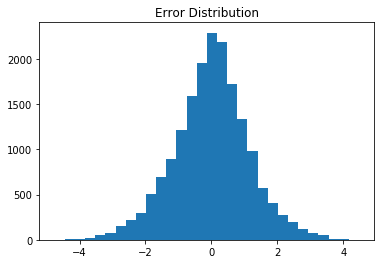

In [40]:
fig, ax = plt.subplots()
ax.hist(model.resid, bins=30)
ax.set_title('Error Distribution')
plt.show()

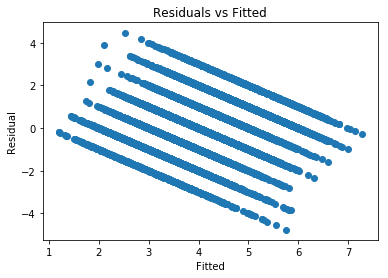

In [41]:
fig, ax = plt.subplots()
ax.scatter(model.fittedvalues,model.resid)
ax.set_xlabel('Fitted')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted')
plt.show()

#### Linear Model Overview

The R-Sqaured for the linear model is .364 on the training data. 

While our linear model does tell us some interesting patterns, we should take a look at the assumptions that were violated in the model. We can see that our error is normally distributed with a mean of zero, but we do not have homoscedasticity in our errors. There appears to be systematic bias, and the relationship between the target variable and the predictors is likely not linear. Also, due to the way we encoded the dummy variables, there is innate multicollinearity within the data that the linear model does not solve. Finally, one could also say that using the 'PARTYID' variable should be removed when predicting due to the innate correlianity with 'POLVIEWS'. The bias found in the Residuals vs Fitted chart also calls into question whether we should use the target variable as a continious variable, or change it to categorical. We can experiment with different models later.

Looking past the violated assumptions, we can generate some hypotheses about the data. While we will not have a lot of confidence with these hypotheses, they can set the baseline for hypotheses in the future. The main hypothesis is that: While holding everything else equal the following variables are significant predictors of a person's political status:
* WRKSLF (Respondent self-emp or works for somebody)
* RACE (Black, White, or Other)
* MARITAL (Marital Status)
* EQUAL (Should government try to equalize wealth gap?)
* CAPPUN (Favor or Oppose death penalty)
* CONLABOR (Does respondent have confidence in the people in the leaders of industry)

In terms of tying this into our problem of advising a politician during a run for office, we could derive great value from proving this hypothesis. We could see that a liberal type of candidate could find great support with other liberals if she/he strong opposes income inequality and and the death penalty at the cost of losing popularity with moderates and conservatives. If one were running a presidential campiagn, one could emphasize these typically liberal views during the run to get onto the presidential ticket and then shift to more moderate views after to appease the moderates. One can also use these relationships as a tool to segregate liberals, conservatives, and moderates in targeted advertising campaigns. 

In [42]:
# Now we can test out the more advanced regression models

test_models = [Lars(eps=15), Ridge(), Lasso(max_iter=15), ElasticNet()]
test_model_names = ['Lars','Ridge','Lasso','ElasticNet']
QuickModel(test_models,test_model_names,X,y)

Lars Cross Validation: [0.0168391  0.01294081 0.02010762 0.01964518 0.02150143]
Ridge Cross Validation: [0.28669407 0.281215   0.37015846 0.37607555 0.36890369]
Lasso Cross Validation: [-4.30778227e-05 -2.30760177e-03 -2.26370785e-05 -1.60134785e-03
 -3.25350249e-05]
ElasticNet Cross Validation: [0.05807953 0.05448864 0.05535677 0.05388694 0.05326197]


On models with defaults, the best model in terms of Rsqaured is ridge regression. On some folds however, it performs worse than the regular regression. Let's experiment with the penalty of the ridge,elasticc, and lasso of the regression in order to see if we can get better results.

In [65]:
import joblib

from sklearn.model_selection import GridSearchCV

# L1 Penality (ie error + alpha * sum of all betas)
lasso_params = {'alpha': [.3,.5, 1, 5, 10, 15, 50]}

# L2 Penality (ie error + alpha * sum of all betas^2)
ridge_params = {'alpha': [.5, 1, 15, 50, 100, 200, 300 ,500]}
 

elastic_params = {
    'alpha': [.5, 1,15, 50,100,200,300,400],
    'l1_ratio' : [.7,.5,.3,.2,.1,.05]
}

# Takes a while to run. I elect to dump to a pickle and load back out to save time.
# ridge_search = GridSearchCV(Ridge(),ridge_params,cv=5).fit(X,y)
# lasso_search = GridSearchCV(Lasso(),lasso_params,cv=5).fit(X,y)
# elastic_search = GridSearchCV(ElasticNet(),elastic_params,cv=5).fit(X,y)

# joblib.dump(ridge_search, "data/models/ridge_model.pkl")
# joblib.dump(lasso_search, "data/models/lasso_model.pkl")
# joblib.dump(elastic_search, "data/models/elastic_model.pkl")

In [71]:
ridge_search = joblib.load("data/models/ridge_model.pkl")
lasso_search = joblib.load('data/models/lasso_model.pkl')
elastic_search = joblib.load('data/models/elastic_model.pkl')

In [72]:
print('Ridge:',ridge_search.best_params_,ridge_search.best_score_)
print('Lasso:',lasso_search.best_params_,lasso_search.best_score_)
print('Elastic:',elastic_search.best_params_,elastic_search.best_score_)

Ridge: {'alpha': 500} 0.3428002734775513
Lasso: {'alpha': 0.3} 0.1589181023816902
Elastic: {'alpha': 0.5, 'l1_ratio': 0.05} 0.3169783173969842


The results of the testing clearly show that Ridge regression is far superior to Lasso, and we need a very high penalty.

In [ ]:
# sklearn.neighbors.KNeighborsClassifier